# Practical task: Yelisiev Vladylsav KA-01mp

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


from scripts.utils import plot_ts, plot_ts_hist, get_stat_overview, compute_pacf_acf, plot_seasonal_decompose

from statsmodels.tsa.seasonal import seasonal_decompose


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data exploration

The dataset we use is data of closing prices for NFLX from NASDAQ from start of 2020 till today:

In [220]:
df =  pd.read_csv("data/SBUX(1).csv").set_index('Date')["Close"]

In [221]:
df.head(), df.tail()

(Date
 2020-04-27    77.739998
 2020-04-28    78.690002
 2020-04-29    76.860001
 2020-04-30    76.730003
 2020-05-01    73.790001
 Name: Close, dtype: float64,
 Date
 2021-04-19    117.599998
 2021-04-20    116.269997
 2021-04-21    116.739998
 2021-04-22    115.919998
 2021-04-23    117.559998
 Name: Close, dtype: float64)

Let's viualize this series and plot it's histogram to get some insights on data structure:

In [222]:
plot_ts(df)

In [223]:
plot_ts_hist(df, bins=1, rug = True)

In [224]:
stats = pd.DataFrame(get_stat_overview(df))
stats.columns = ["Value:"]
stats.T

,Mean,Median,Max,Min,Std,Skewness,Kurtosis,Jarque_Bera,Jarque_Bera_p
Value:,91.529163,89.309998,118.339996,71.57,13.431585,0.145603,-1.368908,20.379663,0.000038


## Stationarity test

### Augmented Dickey-Fuller test
The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.  
  
If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.



> p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  
> p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

  
    
### KPSS test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [225]:
from statsmodels.tsa.stattools import adfuller, kpss
from scripts.utils import inference_statinarity

In [226]:
statio = {}
statio.update(inference_statinarity(df))
statio.update(inference_statinarity(df, "kpss",3))
pd.DataFrame(statio)

/Users/vladyslavyelisieiev/opt/anaconda3/envs/iasa/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




,adfuller,kpss
statistic,0.181379,2.306231
p_value,0.971198,0.010000
critical_value_1%,-3.457215,0.739000
critical_value_5%,-2.873362,0.463000
critical_value_10%,-2.573070,0.347000
critical_value_2.5%,NaN,0.574000


Based upon the significance level of 0.05 and the p-values there is an evidence of series being non-stationary per both ADF and KPSS tests.

## Trend-seasonal decomposition
`period=5` for weekly  
`period=20 #21` for monthly 


In [227]:
result = seasonal_decompose(df, period=5)
plot_seasonal_decompose(result)

In [228]:
sesonal_dec = seasonal_decompose(df, period=20)
plot_seasonal_decompose(sesonal_dec)

In [229]:
plot_ts(df.diff(1).dropna())

In [230]:
statio = {}
statio.update(inference_statinarity(df.diff(1).dropna()))
statio.update(inference_statinarity(df.diff(1).dropna(), "kpss", 3))
pd.DataFrame(statio)

/Users/vladyslavyelisieiev/opt/anaconda3/envs/iasa/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




,adfuller,kpss
statistic,-1.009667e+01,0.156349
p_value,1.086271e-17,0.100000
critical_value_1%,-3.457215e+00,0.739000
critical_value_5%,-2.873362e+00,0.463000
critical_value_10%,-2.573070e+00,0.347000
critical_value_2.5%,NaN,0.574000


Based on tests, looks like the first difference of this series is statinary, thus it has no trend.

## Train/Validation

In [231]:
from sklearn.model_selection import TimeSeriesSplit
ar_ts = df.diff(1).dropna()
fold_ids = list(TimeSeriesSplit(test_size=7, n_splits = 5).split(ar_ts))

# Trim start in order to have same size folds
train_fold_len = min([len(el[0]) for el in fold_ids])
for i in range(len(fold_ids)):
    fold_ids[i] = (fold_ids[i][0][-train_fold_len:], fold_ids[i][1])

In [232]:
fig = go.Figure()
for fold_n, (train_ids, val_ids) in enumerate(fold_ids):
    train_sub_df = ar_ts.iloc[train_ids]
    val_sub_df = ar_ts.iloc[val_ids]
    
    if fold_n<len(fold_ids) - 1:
        fig.add_trace(
            {
                "x": train_sub_df.index,
                "y": train_sub_df + float(fold_n) * 20,
                "line": dict(color="royalblue"),
                "showlegend": False,
                "legendgroup": "Train"
            }
        )
        fig.add_trace(
            {
                "x": val_sub_df.index,
                "y": val_sub_df + float(fold_n) * 20,
                "line": dict(color="crimson"),
                "showlegend": False,
                "mode": "lines",
                "legendgroup": "Valid"
            }
        )
    else:
        fig.add_trace(
            {
                "x": train_sub_df.index,
                "y": train_sub_df + float(fold_n) * 20,
                "line": dict(color="royalblue"),
                "showlegend": True,
                "legendgroup": "Train",
                "name": "Train"
            }
        )
        fig.add_trace(
            {
                "x": val_sub_df.index,
                "y": val_sub_df + float(fold_n) * 20,
                "line": dict(color="crimson"),
                "showlegend": True,
                "mode": "lines",
                "legendgroup": "Valid",
                "name": "Validation"
            }
        )
        


fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True, thickness = 0.075),
        type="date",
    ),
    yaxis =dict(visible = False),
    height = 670,
)
fig.show()


## AR

In [234]:
from sklearn.metrics import mean_squared_error


def compute_pacf_acf(input, acf_bound, pacf_bound, nlags):
    acf_r = acf(input, nlags=nlags)
    pacf_r = pacf(input, nlags=nlags)

    fig = make_subplots(rows=2, cols=1, subplot_titles=("ACF", "PACF"))

    fig.add_trace(go.Scatter(x=np.arange(nlags + 1), y=acf_r, showlegend = False),row=1, col=1)

    fig.add_trace(go.Scatter(x=np.arange(nlags + 1), y=pacf_r,showlegend = False),row=2, col=1)
    fig.add_hrect(
        y0=-acf_bound,
        y1=acf_bound,
        line_width=0,
        fillcolor="turquoise",
        opacity=0.5,
        row=1,
        col=1,
    )
    fig.add_hrect(
        y0= -pacf_bound,
        y1=pacf_bound,
        line_width=0,
        fillcolor="yellowgreen",
        opacity=0.5,
        row=2,
        col=1,
    )

    fig.show()

    print("ACF Important lags: ", np.where(np.abs(acf_r) > acf_bound)[0])
    print("PACF Important lags: ", np.where(np.abs(pacf_r) > pacf_bound)[0])


compute_pacf_acf(ar_ts, 0.1, 0.15, 22)


ACF Important lags:  [0 3 4]
PACF Important lags:  [0 4]


In [39]:
from scripts.metrics import get_all_metrics

In [40]:
print('Equation coefficients:'+str(arma_estimator.only_ar_coefs))
get_all_metrics(target, pred, len(arma_estimator.only_ar_coefs), 'ar')

Equation coefficients:[9.747470699174585, 0.8169984179354545, 0.1480571537281209, -0.044925321734351015, 0.1655868303664797, -0.2152250655549013, 0.029383745806400734, 0.053959842162501555, -0.06177111730103627, 0.0843051776865996, -0.11050973435243805, 0.011871398886921531, 0.11785750915835227, -0.05205005108858308, 0.12032690241751129, -0.18835637806865024, 0.12366466699198737, -0.003403221080609371, -0.01945949669106321, -0.09196245375339379, 0.09771712200707038]


,AIC,RMSE,Durbin-Watson,R-squared,Schwarz criteria,SSE,Adjusted R-sq,Log Likelihood,Mean dependent var,Std dependent var
Value:,8.095644,13.336500,2.020924,0.920310,8.381657,42864.800122,0.833580,-1039.529386,0.000000,12.790860


## ARMA

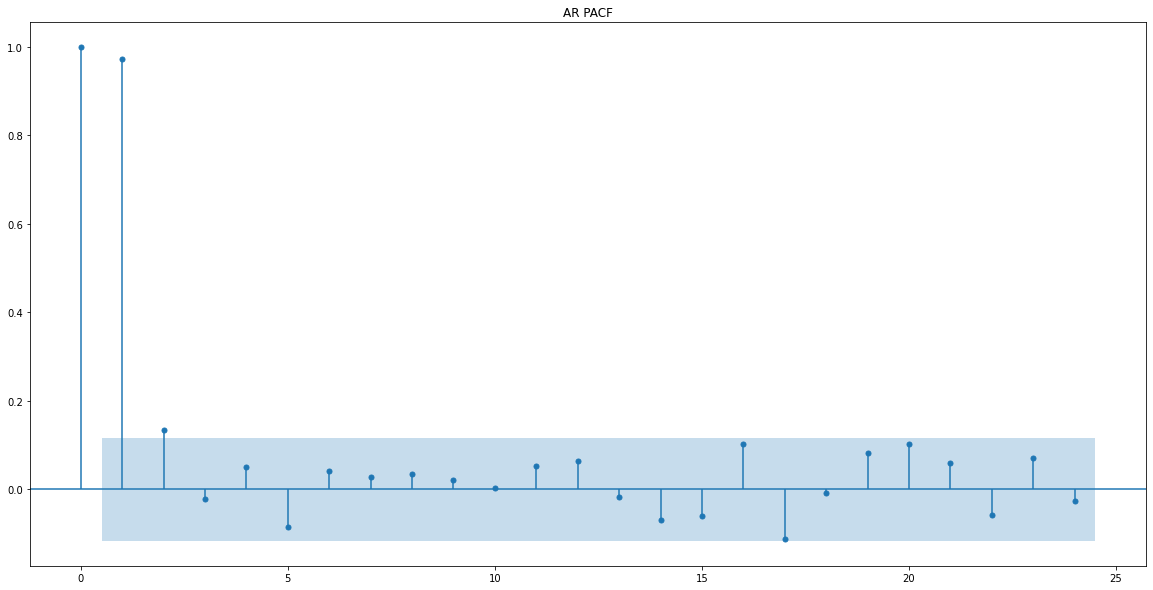

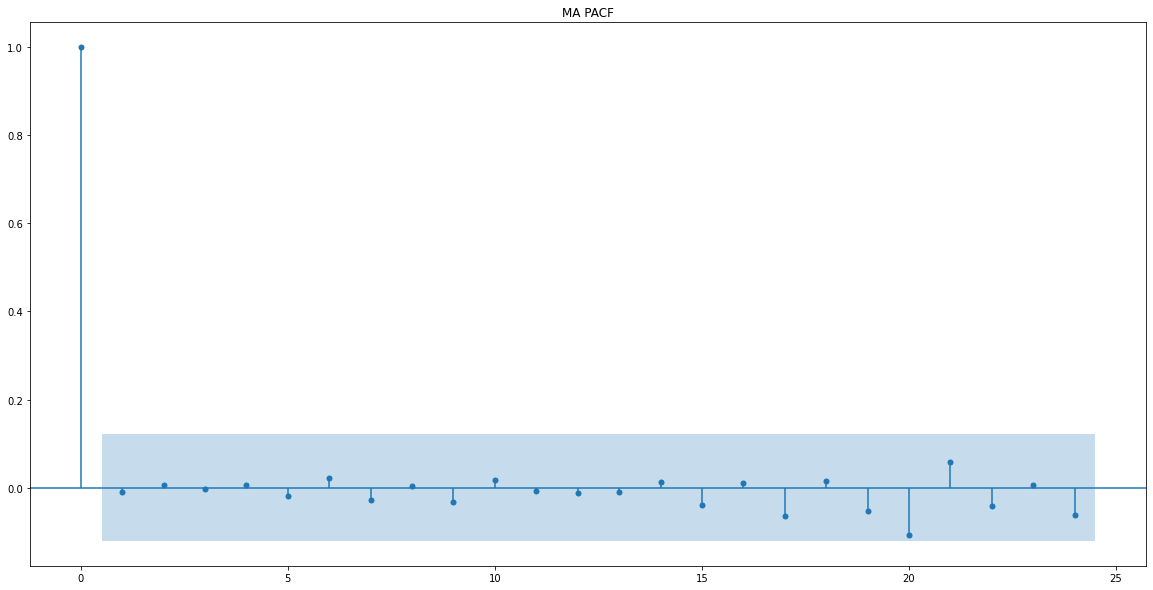

In [41]:
arma_estimator = ARMA(resid=True, window = 5, nlags = 24, ewm=False, ma_threshold=0.1, ar_threshold=0.1)
pred, target = arma_estimator.predict(train)

In [42]:
print('Equation coefficients:'+str(arma_estimator.arma_coefs))
get_all_metrics(target, pred, len(arma_estimator.arma_coefs), 'arma')

Equation coefficients:[-4.935365222915152, 1.535154164305676, -0.037393590667752774, 1.2589463456796135, -1.2535673156235287, -1.61113237895068, 0.29831082907064893, 0.21083542654749513, 0.3691867962161487, 1.7866633400531438, -0.6077997397669658, -1.0990451384806113, -0.18347663386966576, -1.1738036198434303, 0.3322283135228613, 1.3768337853742243, 0.33612324608904454, 0.20366186201585781, -0.5189339014659897, -0.7517085885534271, 0.5395034704386118, 1, -4.583525340709314, 1.5219782796781665, -6.565383221428423, 8.450500496525212, 6.1955946535391835, -5.9280727354990175, -0.36878002916619523, -7.360066897328085, 0.6131930016099569, 9.121339947355882, -0.4178691277541235, 0.17140903474982846, -2.5663839992179343, -0.4404525563745288, 0.21466991847844707, -0.14880213967403094, -0.9451537880214685, 1.6015512508130232, 0.5396856352050382, -1.4582530579291753]


,AIC,RMSE,Durbin-Watson,R-squared,Schwarz criteria,SSE,Adjusted R-sq,Log Likelihood,Mean dependent var,Std dependent var
Value:,12.529668,117.507584,0.011944,0.050722,13.142422,2706374.338804,-0.212258,-1449.030490,91.237344,55.316586
